# CWRU Experiments
## Imports

In [1]:
import pandas as pd
import numpy as np

import lib.transformers as tfs
from sklearn.pipeline import Pipeline

from lib.models import Ganomaly1d, Ganomaly2d, GanomalyFE, GanomalyNet
from lib.visualization import GANomalyBoard, rename_tensorboard_key

from skorch.callbacks import PassthroughScoring, ProgressBar
import torch

from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
import tensorflow

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lib.others import create_dataset

from lib.others import build_model
from lib.visualization import lineplot_comparison

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwruData0 = pd.read_parquet('data/cwru0.parquet')
cwruData1 = pd.read_parquet('data/cwru1.parquet')

cwruData = pd.concat([cwruData0, cwruData1])

## Settings

In [3]:
# torch.manual_seed(0)
# torch.cuda.manual_seed(0)
# np.random.seed(0)

## Creating Datasets

In [4]:
normal_features, normal_labels = create_dataset(cwruData, feature_columns = ['fanEndData', 'driveEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Normal Baseline'], sampleRate = [12000])
normal_features_train, normal_features_test, normal_labels_train, normal_labels_test = train_test_split(normal_features, normal_labels, train_size = 400, test_size= 451, random_state = 0)

ball_features, ball_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Ball Fault'], sampleRate = [12000])
inner_features, inner_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Inner Race Fault'], sampleRate = [12000])
outer_features, outer_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Outer Race Fault'], sampleRate = [12000])


labels_test = pd.concat([ball_labels, inner_labels, outer_labels, normal_labels_test])
features_test = pd.concat([ball_features, inner_features, outer_features, normal_features_test])

normal_features_test = np.array(normal_features_test.to_list())
normal_features_train = np.array(normal_features_train.to_list())

# GridSearchCV

In [5]:
search_parameters = {
    'Model__module__w_app': list(range(0, 31, 30)),
}

In [6]:
#ganomaly_gs = GridSearchCV(model_fft, search_parameters, refit=False, cv=2)

## Building and training the different Models

In [7]:
# model settings
n_z = 600
n_channels = 1
n_feature_maps = 32

fraud_weight = 1
appearant_weight = 30
latent_weight = 1
lambda_weight = 30/31

# training settings
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
n_gpus = 0
workers = 2
batch_size = 16
max_epochs = 50
lr = 0.0001
beta1 = 0.5
beta2 = 0.999

# extra callbacks
callbacks = []

# run number
run = 1000

### Time Series

In [8]:
gan_time_series =\
build_model(
    model = Ganomaly1d,
    
    # model parameters
    input_size = 3136, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # logging parameters
    suffix = 'timeseries' + str(run),
    plot_type = 'lineplot', 
    plot_shape = 3136, 
    plot_latent_shape =600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks
)

In [9]:
pipeline_time_series = \
Pipeline(steps=[
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('reshaper', tfs.ArrayReshaper((1, 3136))),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_time_series)
               ])

In [10]:
pipeline_time_series.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.5158                0.6337        0.7445           16.7406         0.5228       17.3743  14.5712
      2            0.3654                0.3157        0.7391           11.8486         0.1486       12.1643  14.4108
      3            0.2426                0.0955        0.7372            8.0654         0.0504        8.1609  13.5390
      4            0.1539                0.0534        0.7368            5.3804         0.0281        5.4338  13.5080
      5            0.1048                0.0368        0.7360            3.9022         0.0235        3.9390  13.4245
      6            0.0863                0.0270        0.7352            3.3468         0.0228        3.3738  13.8054
      7            0.0811                0.0206        0

Pipeline(steps=[('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x00000196432F5B50>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x00000196432F56D0>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x00000196432F5880>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly1d(
    (fraud_loss): BCELoss()
    (appearant_loss): L1Loss...
          (pyramid-relu-128): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-convt): Conv1d(128, 256, kernel_size=(16,), stride=(4,), bias=False)
          (pyramid-256-batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-relu-256): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-convt): Conv1d(256, 600, kernel_size=(9,), stride=(1,), bias=False)
        )
      )
    )
  ),
))])

### Stacked Time Series

In [11]:
gan_stacked_time_series =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 56, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # logging parameters
    suffix = 'stacked_timeseries' + str(run), 
    plot_type = 'lineplot', 
    plot_shape = 3136, 
    plot_latent_shape =600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks
)

In [12]:
pipeline_stacked_time_series = \
Pipeline(steps=[
                ('reshaper', tfs.ArrayReshaper((1, 56, 56))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_stacked_time_series)
               ])

In [13]:
pipeline_stacked_time_series.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.4573                0.3948        0.7667           14.8285         0.3431       15.2233  13.3857
      2            0.3033                0.0684        0.7782            9.9223         0.0459        9.9907  12.7465
      3            0.1838                0.0295        0.7793            6.3188         0.0258        6.3483  12.0909
      4            0.1138                0.0185        0.7786            4.2151         0.0229        4.2335  12.2503
      5            0.0883                0.0133        0.7781            3.4461         0.0197        3.4594  11.5248
      6            0.0819                0.0105        0.7779            3.2493         0.0149        3.2599  11.4100
      7            0.0803                0.0087        0

Pipeline(steps=[('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x0000019645018A00>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x0000019645018910>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x0000019645018EB0>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly2d(
    (fraud_loss): BCELoss()
    (appearant_loss): L1Loss...
          (pyramid-128-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (pyramid-256-batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-256-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-conv): Conv2d(256, 600, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
    )
  

### Frequency Spectrum

In [14]:
gan_frequency_spectrum =\
build_model(
    model = Ganomaly1d,
    
    # model parameters
    input_size = 1568, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'frequency_spectrum' + str(run), 
    plot_type = 'lineplot', 
    plot_shape = 1568, 
    plot_latent_shape = 600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks
)

In [15]:
pipeline_frequency_spectrum = \
Pipeline(steps=[
                ('fourier_transform', tfs.ArrayFFT()),
                ('reshaper', tfs.ArrayReshaper((1, 1568))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_frequency_spectrum)
               ])

In [16]:
pipeline_frequency_spectrum.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss     dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  ------
      1            0.0362                0.3933        0.7041            1.9231         0.1334        2.3165  7.1429
      2            0.0122                0.1045        0.7020            1.0975         0.0281        1.2020  7.1689
      3            0.0091                0.0576        0.7033            0.9917         0.0156        1.0494  6.7088
      4            0.0079                0.0433        0.7041            0.9520         0.0101        0.9953  7.3541
      5            0.0074                0.0364        0.7049            0.9327         0.0072        0.9690  6.8938
      6            0.0071                0.0311        0.7054            0.9232         0.0058        0.9543  7.0070
      7            0.0069                0.0272        0.7058   

Pipeline(steps=[('fourier_transform',
                 <lib.transformers.ArrayFFT object at 0x0000019643363760>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x0000019643363D00>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x0000019643363790>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x0000019643363640>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[i...
          (pyramid-relu-64): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-64-128-convt): Conv1d(64, 128, kernel_size=(16,), stride=(4,), bias=False)
          (pyramid-128-batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-relu-128): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-128-1-convt): Conv1d(128, 600, kernel_size=(9,), stride=(1,), bias=False)
        )
      )
    )
  )

### Spectrogram

In [17]:
gan_spectrogram =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 56, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'spectrograms' + str(run),
    plot_type = 'image', 
    plot_shape = 56, 
    plot_latent_shape =600, 
    n_samples = 36,

    # extra callbacks
    callbacks = callbacks
)

In [18]:
pipeline_spectrogram = \
Pipeline(steps=[
                ('stft_transform', tfs.ArraySTFT()),
                ('reshaper', tfs.ArrayReshaper((1, 56, 56))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_spectrogram)
               ])

In [19]:
pipeline_spectrogram.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.0585                0.2674        0.7690            2.7355         0.2115        3.0029  12.1047
      2            0.0239                0.0389        0.7771            1.5253         0.0300        1.5642  11.4709
      3            0.0203                0.0233        0.7774            1.4049         0.0170        1.4282  11.6453
      4            0.0192                0.0174        0.7773            1.3666         0.0121        1.3839  13.0348
      5            0.0188                0.0141        0.7772            1.3506         0.0091        1.3647  15.6711
      6            0.0186                0.0120        0.7772            1.3422         0.0073        1.3542  16.3636
      7            0.0184                0.0104        0

Pipeline(steps=[('stft_transform',
                 <lib.transformers.ArraySTFT object at 0x000001964517A4F0>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000001964517A8E0>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x0000019643363910>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x00000196433637C0>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[ini...
          (pyramid-128-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (pyramid-256-batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-256-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-conv): Conv2d(256, 600, kernel_size=(3, 3), stride=(1, 1), bias=False)
   

### Feature Extraction

In [20]:
gan_feature_extraction =\
build_model(
    model = GanomalyFE,
    
    # model parameters
    input_size = 4, 
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'feature_extraction' + str(run), 
    plot_type = 'barplot', 
    plot_shape = 16, 
    plot_latent_shape = 32, 
    n_samples = 4,

    # extra callbacks
    callbacks = callbacks
)

In [21]:
pipeline_feature_extraction = \
Pipeline(steps=[
                ('feature_extractor', tfs.FeatureExtractor()),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('reshaper', tfs.ArrayReshaper((1, 4, 4))),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_feature_extraction)
              ])

In [22]:
pipeline_feature_extraction.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss     dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  ------
      1            0.0857                0.4252        0.6075            3.1781         0.0009        3.6033  2.2906
      2            0.0856                0.3888        0.6156            3.1841         0.0009        3.5729  2.1891
      3            0.0853                0.3267        0.6265            3.1870         0.0019        3.5137  2.1993
      4            0.0843                0.2929        0.6267            3.1589         0.0046        3.4518  2.1612
      5            0.0818                0.2444        0.6266            3.0888         0.0080        3.3331  2.3165
      6            0.0778                0.1902        0.6172            2.9585         0.0084        3.1487  2.1532
      7            0.0744                0.1441        0.6104   

Pipeline(steps=[('feature_extractor',
                 <lib.transformers.FeatureExtractor object at 0x00000196454E1D90>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x00000196454E1730>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x00000196454E15B0>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x00000196454E1820>),
                ('model',
                 <class 'lib.models.Ganomal...
      )
      (fake_encoder): EncoderFE(
        (main): Sequential(
          (initial-conv-1-4): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), bias=False)
          (initial-4-batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (initial-4-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-conv-4-8): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1), bias=False)
        )
      )
    )
  ),
))])

## Results


### Timeseries

In [23]:
features_test = np.array(features_test.tolist())
predictions = pipeline_time_series.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

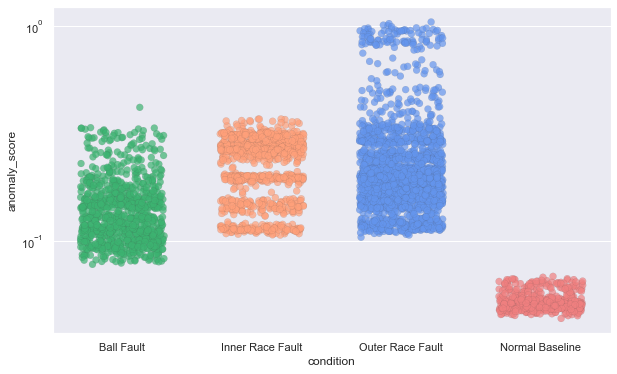

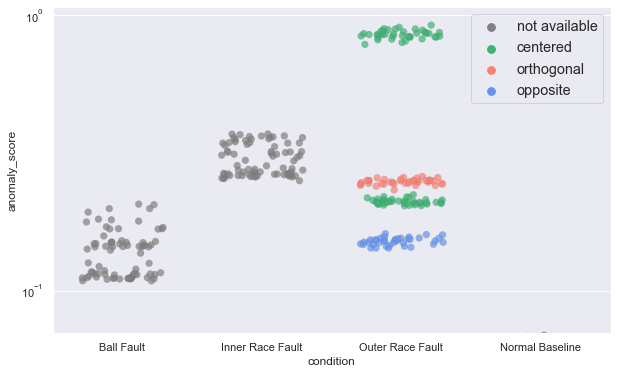

In [24]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]


fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

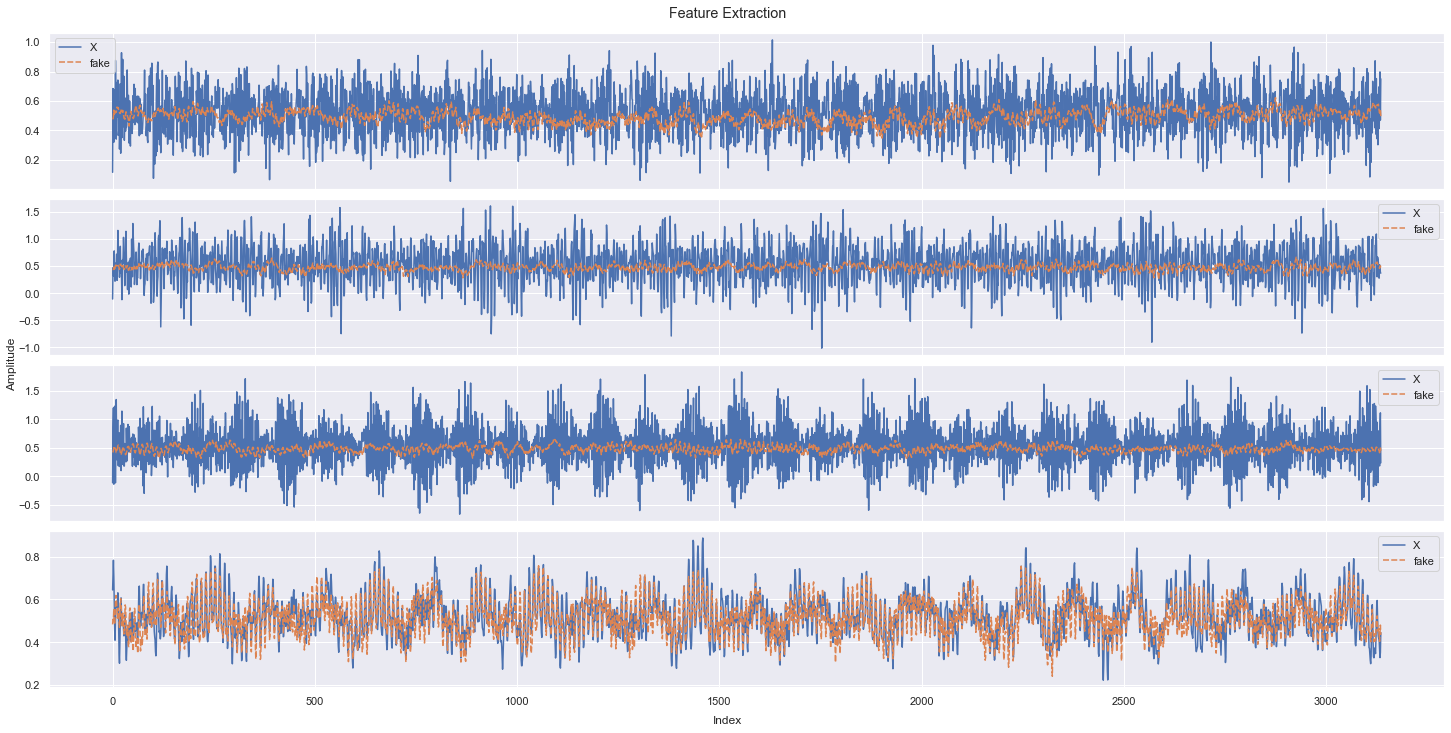

In [25]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

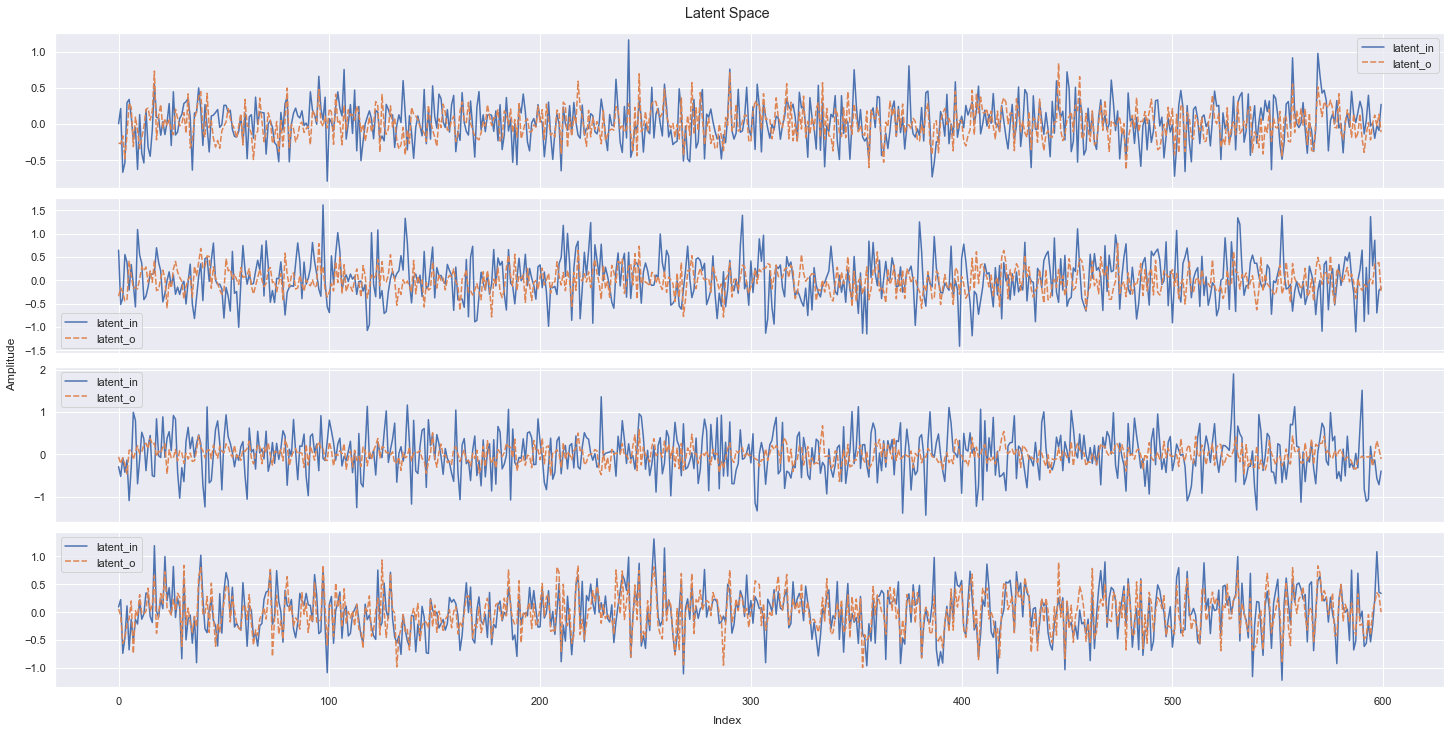

In [26]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### Stacked Timeseries

In [27]:
features_test = np.array(features_test.tolist())
predictions = pipeline_stacked_time_series.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

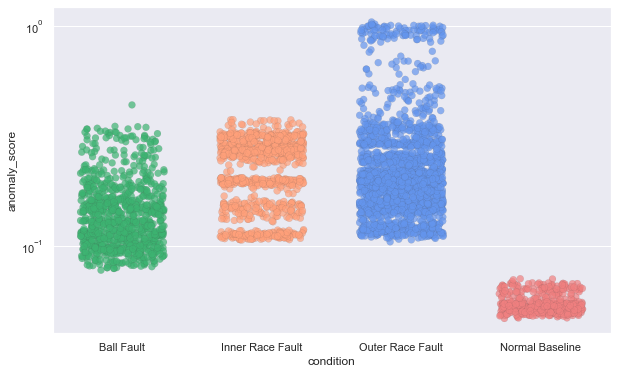

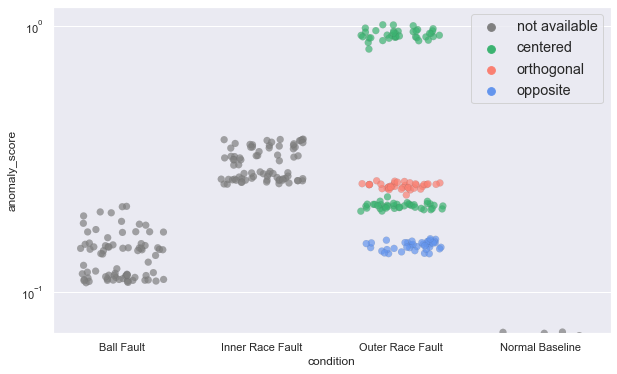

In [28]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

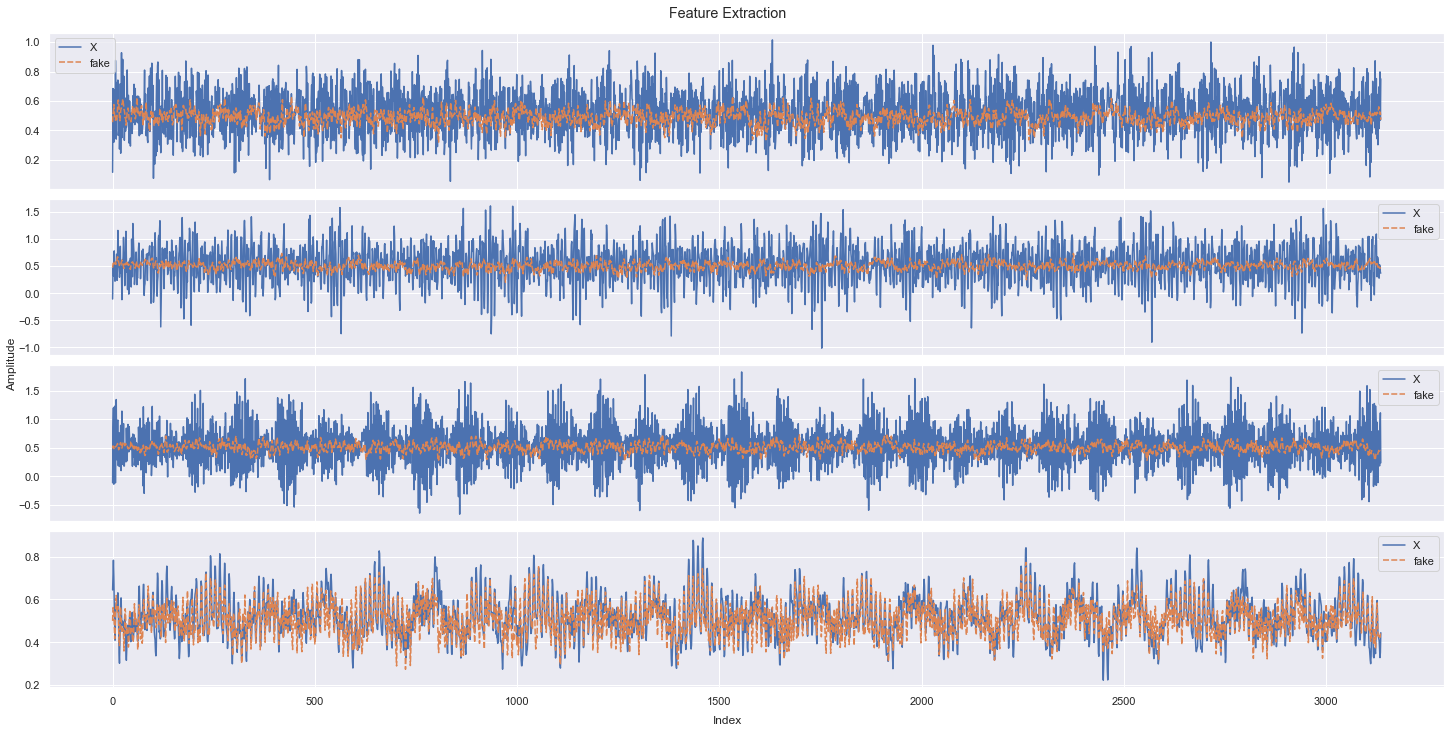

In [29]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

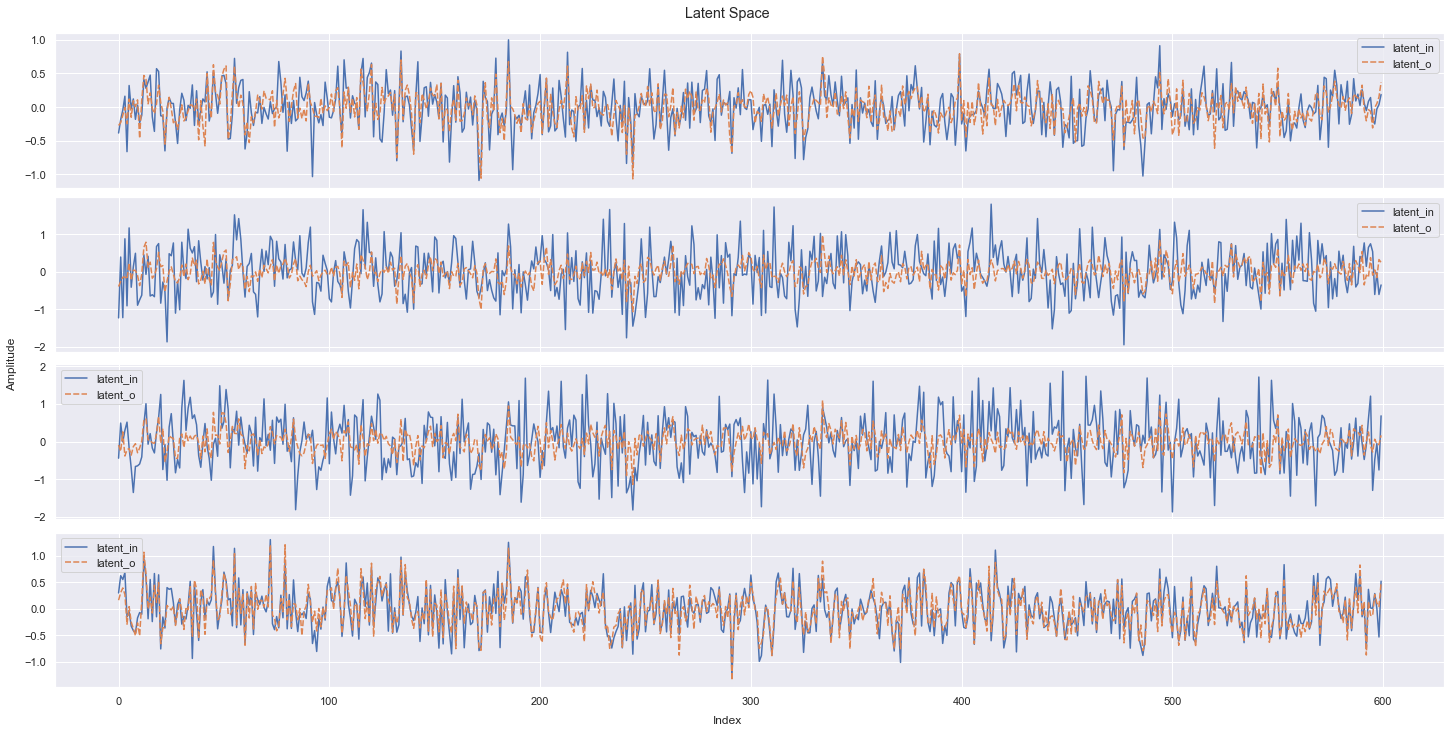

In [30]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### FFT

In [31]:
features_test = np.array(features_test.tolist())
predictions = pipeline_frequency_spectrum.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

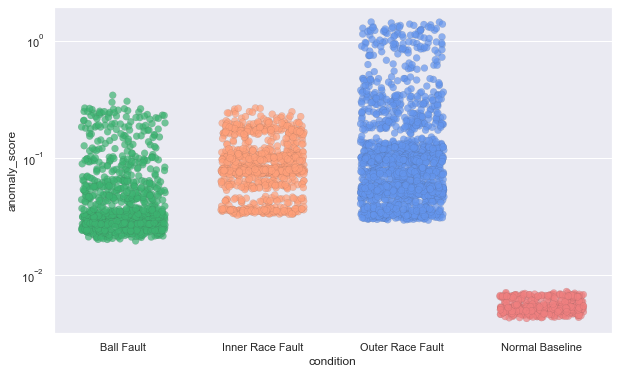

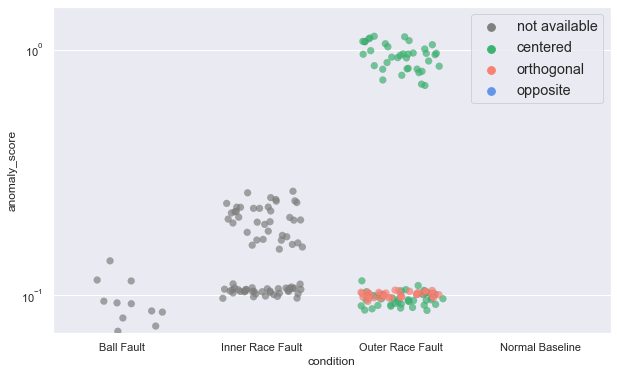

In [32]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

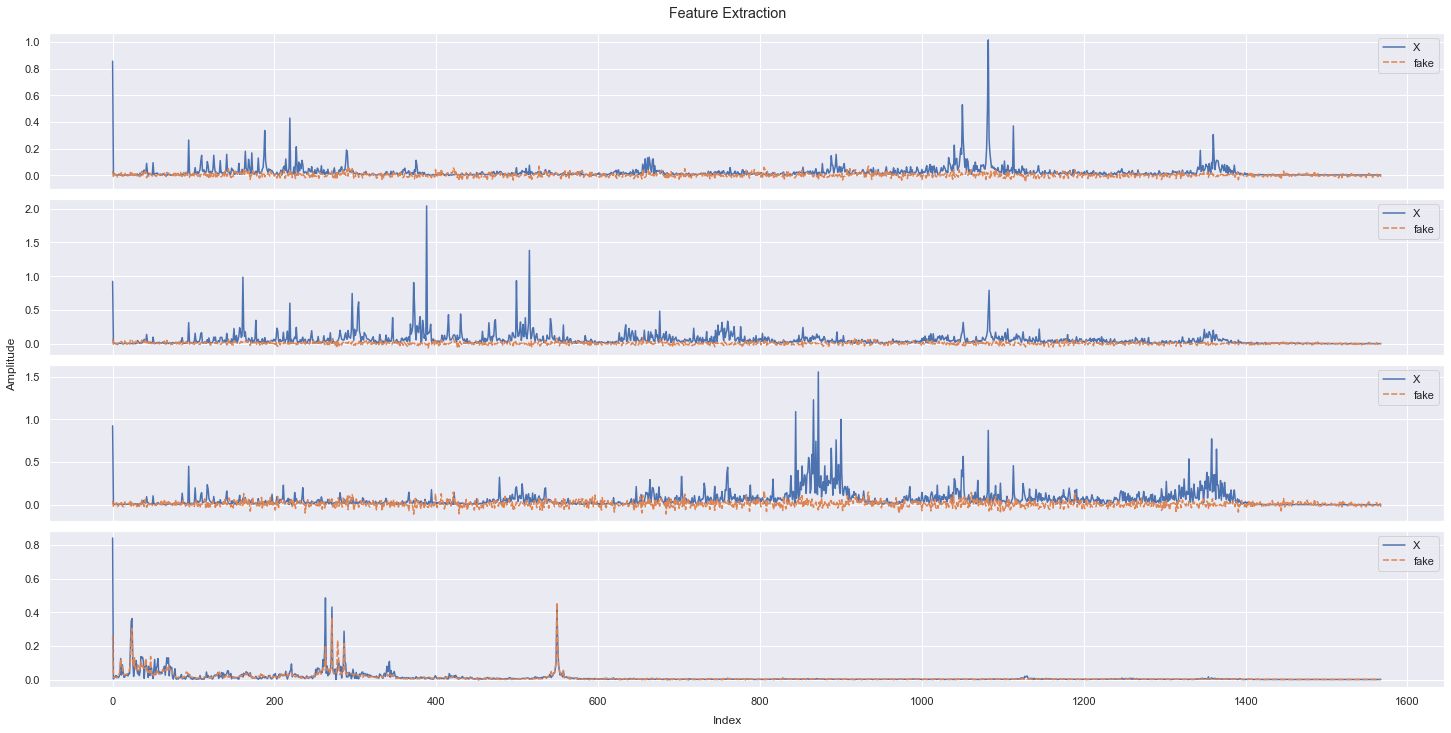

In [33]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

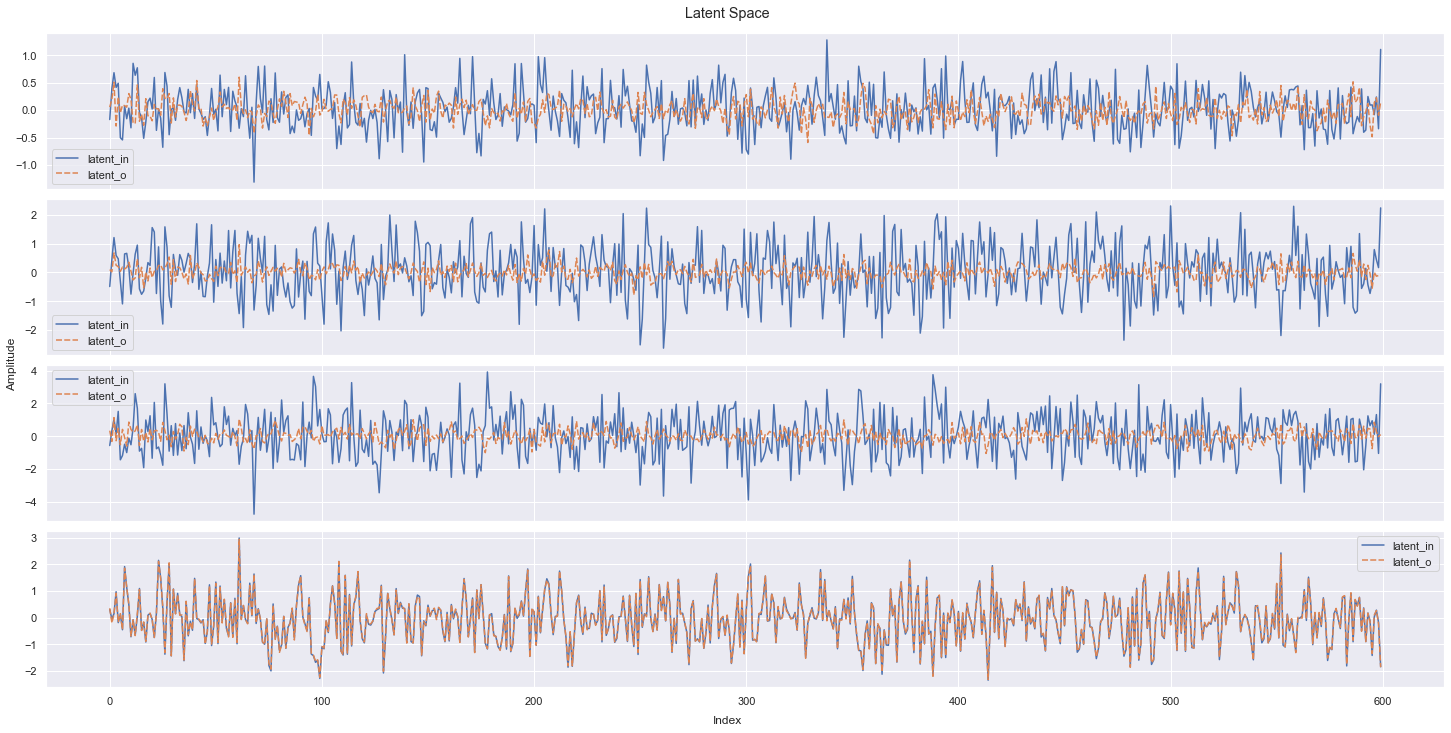

In [34]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### STFT

In [35]:
features_test = np.array(features_test.tolist())
predictions = pipeline_spectrogram.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

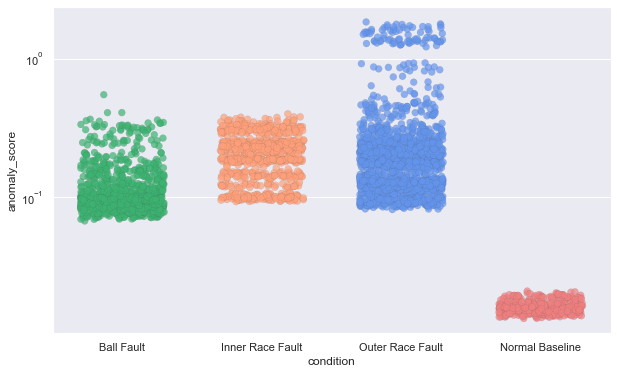

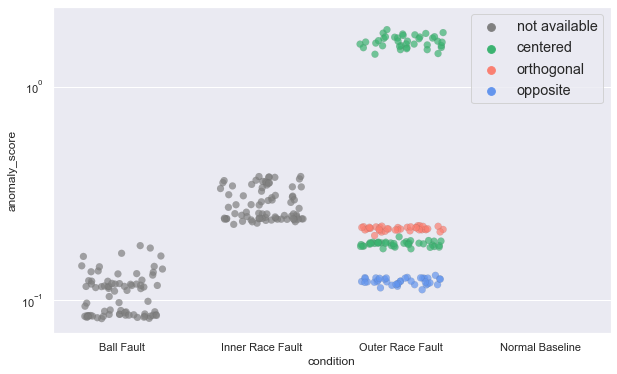

In [36]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

### Feature Extraction

In [37]:
features_test = np.array(features_test.tolist())
predictions = pipeline_feature_extraction.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

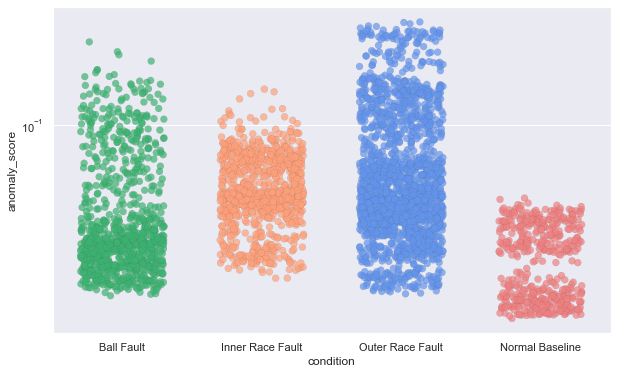

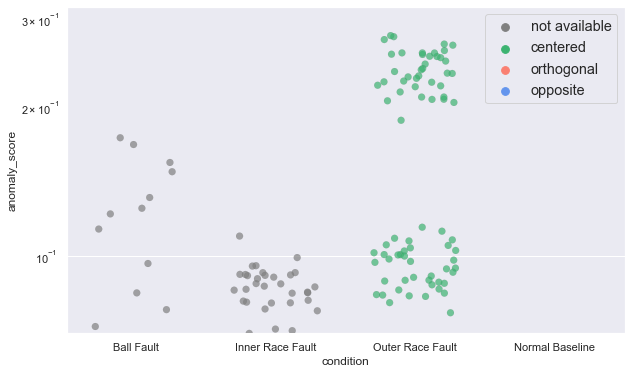

In [38]:
sns.set_style('darkgrid')

sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')